In [1]:
import numpy as np
import os 
import tensorflow as tf
import tensorflow_datasets as tfds
import pathlib
import cv2
import matplotlib.pyplot as plt

In [3]:

data_dir = '/Users/nopparuj/makima_tsuki/food-101/images'
data_dir = pathlib.Path(data_dir)
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)
# print(os.listdir(data_dir))

5000


In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset="training",seed=123,image_size=(300,300),batch_size=32)
val_ds = tf.keras.utils.image_dataset_from_directory(data_dir,validation_split=0.2,subset="validation",seed=123,image_size=(300,300),batch_size=32)
class_names = train_ds.class_names
print(class_names)

Found 5000 files belonging to 5 classes.
Using 4000 files for training.
Metal device set to: Apple M2

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-11-12 11:56:09.008792: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-12 11:56:09.009104: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 5000 files belonging to 5 classes.
Using 1000 files for validation.
['french_fries', 'fried_rice', 'pad_thai', 'steak', 'sushi']


2022-11-12 11:56:09.364531: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


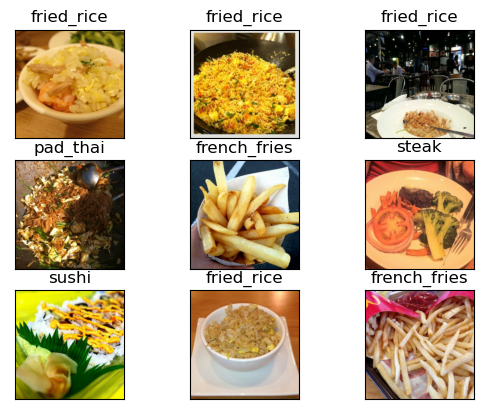

In [5]:
# Show some random image
plt.figure(1)
for images, labels in train_ds.take(1):
    for i in range(9):
        plt.subplot(3,3,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i].numpy().astype(np.uint8))
        plt.title(class_names[labels[i]])
plt.show()

In [6]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print("\n",labels_batch.shape)
    break

(32, 300, 300, 3)

 (32,)


In [7]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 0.99901336


In [8]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)


In [9]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [10]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])
  

In [12]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=20
)

Epoch 1/20
125/125 [==============================] - 48s 380ms/step - loss: 0.4670 - accuracy: 0.8260 - val_loss: 1.8238 - val_accuracy: 0.4780
Epoch 2/20
125/125 [==============================] - 49s 391ms/step - loss: 0.3750 - accuracy: 0.8645 - val_loss: 2.3415 - val_accuracy: 0.4770
Epoch 3/20
125/125 [==============================] - 47s 379ms/step - loss: 0.2515 - accuracy: 0.9073 - val_loss: 2.9891 - val_accuracy: 0.4460
Epoch 4/20
125/125 [==============================] - 49s 388ms/step - loss: 0.1781 - accuracy: 0.9445 - val_loss: 3.6939 - val_accuracy: 0.4100
Epoch 5/20
125/125 [==============================] - 48s 381ms/step - loss: 0.1646 - accuracy: 0.9485 - val_loss: 2.8248 - val_accuracy: 0.4480
Epoch 6/20
125/125 [==============================] - 49s 393ms/step - loss: 0.0965 - accuracy: 0.9723 - val_loss: 3.3927 - val_accuracy: 0.4730
Epoch 7/20
125/125 [==============================] - 48s 386ms/step - loss: 0.0273 - accuracy: 0.9925 - val_loss: 3.7763 - val_ac

In [47]:
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(val_ds)
# i = 15 
# For i = 15, should be sushi #But it predicts as french fries
# i = 17
# For i = 17, shold be fried rice, printed 1! so it's correct
# i = 4 # Correct!
# i = 24 # Correct!
i = 6 # Correct!
# i = 0 #padthai = steak wut?!
predictions[i]
print(np.argmax(predictions[i]))
# 0 - french fries 1 - fried rice 2 - pad thai 3 - steak 4 - sushi


 1/32 [..............................] - ETA: 3s

2022-11-12 12:52:17.702924: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


32/32 [==============================] - 2s 65ms/step
3


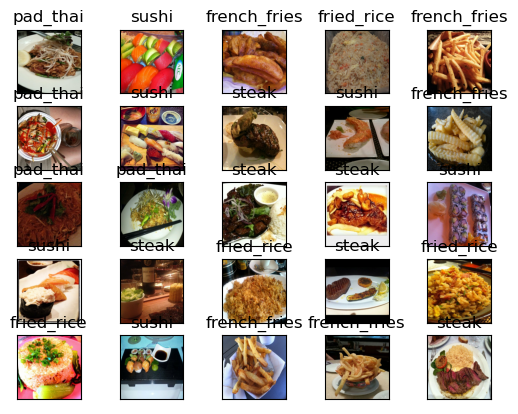

In [36]:
#Use this to check from validation data
plt.figure(1)
for images, labels in val_ds.take(1):
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i].numpy().astype(np.uint8))
        plt.title(class_names[labels[i]])
plt.show()